In [20]:
from config import get_config
import os
from functools import partial
import cv2
from PIL import Image
from torchvision import transforms as trans
from torchvision.datasets import DatasetFolder
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib
# %matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
class CBIS_PatchDataSet_INMEM(Dataset):
    def __init__(self, seed=None, im_resize=224, prob_bkg=.5, no_bkg=False):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.bkg_label = 0 #2 TODO exp
        self.im_resize = im_resize
        self.prob_bkg = prob_bkg
        self.seed = seed
        
        class RightAngleTransform:
            """Rotate by one of the right angles."""

            def __init__(self):
                self.angles = [0, 90, 180, 270]

            def __call__(self, x):
                angle = np.random.choice(self.angles)
                return trans.functional.rotate(x, angle)

        self.rotation_transform = trans.Compose([
            trans.ToTensor(),
        ])

    def patch_transform_func(self, image, mask):
        angles = [0, 90, 180, 270]
        angle = np.random.choice(angles)
        image = trans.functional.rotate(image, angle)
        mask = trans.functional.rotate(mask, angle)

        if random.random() > 0.5:
            image = trans.RandomHorizontalFlip(1)(image)
            mask = trans.RandomHorizontalFlip(1)(mask)
        if random.random() > 0.5:
            image = trans.RandomVerticalFlip(1)(image)
            mask = trans.RandomVerticalFlip(1)(mask)
        return trans.ToTensor()(image), trans.ToTensor()(mask)

    def get_cont(self, im):
        _, contours, _ = cv2.findContours(im.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cont_areas = [cv2.contourArea(cont) for cont in contours]
        idx = np.argmax(cont_areas)  # find the largest contour.
        rx, ry, rw, rh = cv2.boundingRect(contours[idx])
        return rx, ry, rw, rh

    def sample_patches(self, index, pos_cutoff=.9, neg_cutoff=.1, hard_center=True):
        img, roi_image = self.mam_im[index], self.roi_im[index]
        patch_size = self.patch_size
        rng = np.random.RandomState(self.seed or None)
        roi_f = (np.array(roi_image) > 0).astype(float)
        roi_size = roi_f.sum()
        patch_cover = cv2.blur(roi_f, (patch_size, patch_size))
        roi_cover = (patch_cover * (patch_size ** 2)) / roi_size

        # TODO maybe tad extreme?
        # edge case - might be less then thresh
        image_thresh = max(patch_cover.max(), roi_cover.max())
        pos_cutoff = image_thresh * .95 if image_thresh < pos_cutoff else pos_cutoff

        # abnormalities
        abn_filter = (patch_cover > pos_cutoff) | (roi_cover > pos_cutoff)
        abn_targets = np.argwhere(abn_filter)

        nb_bkg = sum(np.random.binomial(1, self.prob_bkg, self.patch_num))
        nb_abn = self.patch_num - nb_bkg

        # force center in image and sample
        targets = []
        if nb_abn > 0:
            abn_targets = abn_targets[(abn_targets[:, 0] + (patch_size // 2) < roi_f.shape[0]) &
                                      (abn_targets[:, 0] - (patch_size // 2) > 0) &
                                      (abn_targets[:, 1] + (patch_size // 2) < roi_f.shape[1]) &
                                      (abn_targets[:, 1] - (patch_size // 2) > 0)]
            if hard_center:
                upleft_x, upleft_y, rw, rh = self.get_cont(np.array(roi_image))
                abn_targets = abn_targets[(abn_targets[:, 0] < upleft_y + rh) &
                                          (abn_targets[:, 0] > upleft_y) &
                                          (abn_targets[:, 1] < upleft_x + rw) &
                                          (abn_targets[:, 1] > upleft_x)]
            assert len(abn_targets) > 0  # TODO make sure no funny buisness
            targets = abn_targets[rng.choice(len(abn_targets), nb_abn)]

        # background
        if nb_bkg > 0:
            bkg_filter = (patch_cover < neg_cutoff) & (roi_cover < neg_cutoff)
            bkg_targets = np.argwhere(bkg_filter)
            # force center in image and sample
            bkg_targets = bkg_targets[(bkg_targets[:, 0] + (patch_size // 2) < roi_f.shape[0]) &
                                      (bkg_targets[:, 0] - (patch_size // 2) > 0) &
                                      (bkg_targets[:, 1] + (patch_size // 2) < roi_f.shape[1]) &
                                      (bkg_targets[:, 1] - (patch_size // 2) > 0)]
            assert len(bkg_targets) > 0  # TODO make sure no funny buisness
            bkg_targets = bkg_targets[rng.choice(len(bkg_targets), nb_bkg)]
            targets = np.concatenate([targets, bkg_targets]) if targets != [] else bkg_targets

        roi_patches = []
        patches = []
        for target_x, target_y in targets:
            patch = img.crop((target_y - patch_size // 2, target_x - patch_size // 2,
                              target_y + patch_size // 2, target_x + patch_size // 2))
            if self.with_roi:
                roi_patch = roi_image.crop((target_y - patch_size // 2, target_x - patch_size // 2,
                                  target_y + patch_size // 2, target_x + patch_size // 2))
                patch, roi_patch = self.patch_transform_func(patch, roi_patch)
                patches.append(patch)
                roi_patches.append(roi_patch)
            else:
                patches.append(self.patch_transform(patch))

        return ([patches, roi_patches] if self.with_roi else patches), nb_abn, nb_bkg

    def __getitem__(self, index):
        # Open image
        patches, nb_abn, nb_bkg = self.sample_patches(index)
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = ([self.label_arr[index]] * nb_abn) + ([self.bkg_label] * nb_bkg)
        return (patches, single_image_label)

    def __len__(self):
        return self.data_len

/home/ubuntu/Git/CBIS-DDSM_alpha/CBIS_dataloader.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  os.listdir(csv_dir) if 'train' in x])
/home/ubuntu/Git/CBIS-DDSM_alpha/CBIS_dataloader.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  os.listdir(csv_dir) if 'test' in x])


In [260]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.patches import Circle, Rectangle
from matplotlib.collections import PatchCollection
from torchvision import transforms as trans
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from functools import partial
import tqdm

In [320]:
size = 244
re_size = trans.Resize(244)
blue = [(0,0),(0,0),(225,225)]
red = [(225,225), (0,0), (0,0)]
f = partial(random_shapes, image_shape=(size, size), max_shapes=1, multichannel=True, 
        min_size=size//10, max_size=(size*9)//10)
def get_im():
    shape_bit = (random.random() < .5)
    shape = 'rectangle' if shape_bit else 'circle'
    color_bit = (random.random() < .5)
    color = red if color_bit else blue
    arr = f(shape=shape, intensity_range=color)[0]
    
    return arr#mage.fromarray(arr), (shape_bit, color_bit)

In [578]:
for im,label in tqdm.tqdm(ShapeDataSet(prob_bkg=0.5, aug=False, n_shapes=2, n_colors=2), total=1e3):
    pass

100%|██████████| 1000/1000.0 [00:01<00:00, 556.52it/s]


In [536]:
ds = ShapeDataSet(prob_bkg=0.2, aug=True, n_shapes=3)

In [537]:
ds.label_map

{(0, 0): 1, (0, 1): 2, (1, 0): 3, (1, 1): 4, (2, 0): 5, (2, 1): 6}

In [575]:
class ShapeDataSet(Dataset):
    def __init__(self, seed=None, im_size=224, prob_bkg=.5, no_bkg=False, ds_size=1e3, aug=False, n_shapes=2, n_colors=2):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.ds_size = ds_size
        self.bkg_label = 0 
        self.im_size = im_size
        self.prob_bkg = 0 if no_bkg else prob_bkg
        self.im_gen = partial(random_shapes, image_shape=(self.im_size, self.im_size), max_shapes=1, 
                              multichannel=True, min_size=self.im_size//4, max_size=(self.im_size*9)//4)
        self.null_im = Image.fromarray(np.ones(shape=(self.im_size, self.im_size, 3), dtype=np.uint8)*255)
        self.aug = aug
        self.n_shapes = n_shapes
        assert n_shapes in [1,2,3]
        self.n_colors = n_colors
        assert n_colors in [1,2,3]
        
        self.shapes = ['rectangle', 'circle', 'triangle'][:n_shapes]
        self.colors = [[(255,255), (0,0), (0,0)], [(0,0), (255,255), (0,0)], [(0,0), (0,0), (255,255)]]
        np.random.shuffle(self.colors)
        self.colors = self.colors[:n_colors]
        self.label_map = {v:k+(1-int(no_bkg)) for k,v in enumerate(product(range(n_shapes),range(n_colors)))}
        
        class AddGaussianNoise(object):
            def __init__(self, mean=0., std=1.):
                self.std = std
                self.mean = mean

            def __call__(self, tensor):
                return tensor + (torch.randn(tensor.size()) * self.std) + self.mean

            def __repr__(self):
                return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
            
        self.transform = trans.Compose([
            Image.fromarray,
            trans.Pad(self.im_size, fill=(255,255,255)),
            trans.RandomAffine((-90, 90)),
            trans.CenterCrop(self.im_size),
            trans.ToTensor(),
            #AddGaussianNoise(0., .005)
        ])
    
    def gen_im(self):
        try:
            if (random.random() < self.prob_bkg):
                im = self.null_im 
                label = self.bkg_label
                return im, label
            else:
                shape_bit = random.choice(range(self.n_shapes))
                shape = self.shapes[shape_bit]
                color_bit = random.choice(range(self.n_colors))
                color = self.colors[color_bit]
                im = self.im_gen(shape=shape, intensity_range=color)[0]
                label = self.label_map[(shape_bit, color_bit)]
                return Image.fromarray(im) if (not self.aug and shape_bit) else self.transform(im), label
        except Exception as e:
            print(e)
    
    def __getitem__(self, index):
        if index >= self.ds_size:
            raise IndexError
        return self.gen_im()

    def __len__(self):
        return self.ds_size

In [563]:
%timeit random.choice(range(3))

1.1 µs ± 0.144 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [564]:
random.choice(range(3))

2

In [562]:
%timeit np.random.choice([3,2])

11.8 µs ± 43.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [552]:
%timeit np.random.permutation([3])

5.22 µs ± 31.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [550]:
np.random.permutation([3,1])

array([1, 3])

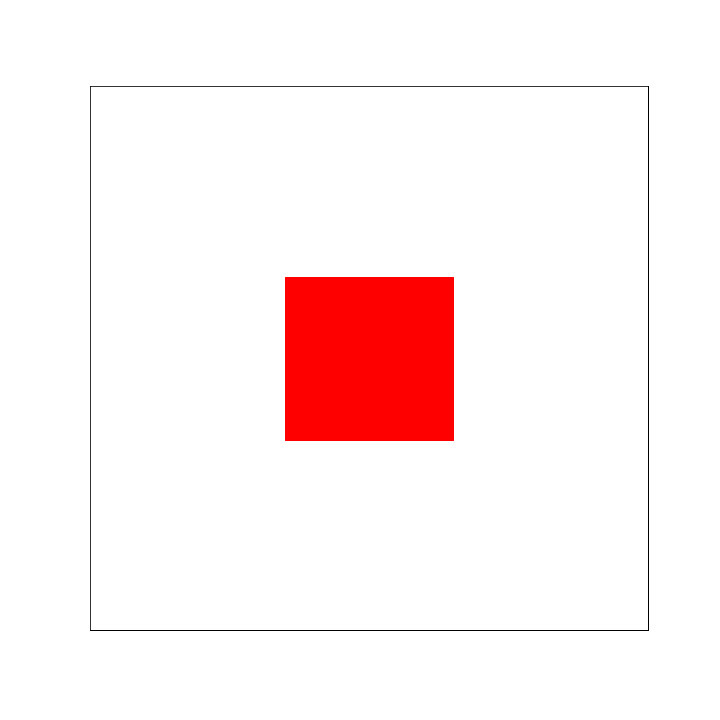

In [113]:
s, (width, height) = canvas.print_to_buffer()
Image.fromarray(np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape((height, width, 3)))

In [579]:
from skimage.draw import random_shapes

In [38]:
result = random_shapes((128, 128), max_shapes=1, shape='rectangle', multichannel=True, min_size=.3)

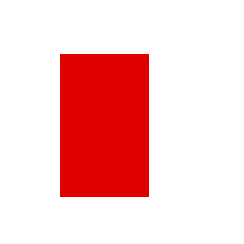

In [117]:
size = 244
blue = [(0,0),(0,0),(225,225)]
red = [(225,225), (0,0), (0,0)]
Image.fromarray(random_shapes((size, size), max_shapes=1, shape='rectangle', multichannel=True, min_size=size//10,
                             max_size=(size*9)//10, intensity_range=red)[0])

In [103]:
random_shapes((128, 128), max_shapes=1, shape='rectangle', multichannel=True, min_size=20,
                             intensity_range=[(0,0),(0,0),(225,225)])[0].shape

(128, 128, 3)

In [47]:
dloader_args = {
            'batch_size': 5,
            'pin_memory': True,
            'num_workers': 20,
            'drop_last': False,
            'shuffle': False
}

In [48]:
from torch.utils.data import Dataset, DataLoader
conf.data_mode = 'image_file'
conf.train_folder = conf.data_path / conf.data_mode / 'train'
conf.test_folder = conf.data_path / conf.data_mode / 'test'
file_ext = ('.png',)
og_resize=(1152,896) 
patch_size=224
src_transform = trans.Compose([
    Image.fromarray,
    trans.Resize(og_resize),
    trans.Pad(patch_size // 2),
    trans.ToTensor()
])
grey_loader = partial(cv2.imread, flags=cv2.IMREAD_GRAYSCALE)

dataset = DatasetFolder(conf.train_folder, extensions=file_ext,
                                     loader=grey_loader, transform=src_transform)
train_loader = DataLoader(dataset, **dloader_args)

In [49]:
for im, label in tqdm.tqdm_notebook(train_loader, total=len(train_loader)):
    break

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [57]:
src_transform = trans.Compose([
    Image.fromarray,
    trans.Resize(og_resize),
    trans.Pad(patch_size // 2),
])
grey_loader = partial(cv2.imread, flags=cv2.IMREAD_GRAYSCALE)
dataset = DatasetFolder(conf.train_folder, extensions=file_ext, loader=grey_loader, transform=src_transform)

In [2]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, mode='train', sample=1):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.nb_abn = 10
        self.nb_bkg = 10
        
        self.og_resize = (1152,896)
        self.patch_size = 225
        self.seed = 1234
        csv_dir = 'csv_files'
        self.table = pd.concat([pd.read_csv(os.path.join(csv_dir, x)) for x in os.listdir(csv_dir) if mode in x])
        # adding label for pos patches, bkg patch is 0
        self.table['pos_label'] = pd.Series(
            zip(self.table['label'], self.table['abnormality type'])).astype('category').cat.codes + 1
        
        # 1 know faulty sample
        self.table = self.table[self.table['ROI mask file path png']!='Calc-Training_P_00474_LEFT_MLO_1.png']
        
        roi_path_func = lambda row: os.path.join('data/ROI_file', mode, str(row['label']), row['ROI mask file path png'])
        mam_path_func = lambda row: os.path.join('data/image_file', mode, str(row['label']), row['image file path png'])
        
        # image paths
        self.roi_paths = self.table.apply(roi_path_func, axis=1).values
        self.mam_paths = self.table.apply(mam_path_func, axis=1).values
        
        # abels
        self.label_arr = self.table['pos_label'].astype(int).values
        # Calculate len
        self.data_len = len(self.label_arr)

        self.grey_loader = partial(cv2.imread, flags=cv2.IMREAD_GRAYSCALE)
        self.transform = trans.Compose([
            Image.fromarray,
            trans.Resize(self.og_resize),
            trans.Pad(self.patch_size // 2),
        ])
        
        class RightAngleTransform:
            """Rotate by one of the right angles."""

            def __init__(self):
                self.angles = [0, 90, 180, 270]

            def __call__(self, x):
                angle = np.random.choice(self.angles)
                return trans.functional.rotate(x, angle)

        self.patch_transform = trans.Compose([
            trans.RandomHorizontalFlip(),
            trans.RandomVerticalFlip(),
            RightAngleTransform(),
            trans.ToTensor()
        ])
        
    def sample_patches(self, img, roi_image, pos_cutoff=.9, neg_cutoff=.1, nb_abn=10, nb_bkg=10):
        patch_size = self.patch_size
        rng = np.random.RandomState(self.seed)
        roi_f = (np.array(roi_image) > 0).astype(float)
        roi_size = roi_f.sum()
        patch_cover = cv2.blur(roi_f, (patch_size, patch_size))
        roi_cover = (patch_cover * (patch_size ** 2)) / roi_size

        # TODO maybe skip
        # edge case - might be less then thresh
        image_thresh = max(patch_cover.max(), roi_cover.max())
        pos_cutoff = image_thresh * .95 if image_thresh < pos_cutoff else pos_cutoff

        # abnormalities
        abn_filter = (patch_cover > pos_cutoff) | (roi_cover > pos_cutoff)
        abn_targets = np.argwhere(abn_filter)

        # force center in image and sample
        abn_targets = abn_targets[(abn_targets[:, 0] + (patch_size // 2) < roi_f.shape[0]) &
                                  (abn_targets[:, 0] - (patch_size // 2) > 0) &
                                  (abn_targets[:, 1] + (patch_size // 2) < roi_f.shape[1]) &
                                  (abn_targets[:, 1] - (patch_size // 2) > 0)]
        if len(abn_targets) < 1: return []  # TODO make sure no funny buisness
        abn_targets = abn_targets[rng.choice(len(abn_targets), self.nb_abn)]

        # background
        bkg_filter = (patch_cover < neg_cutoff) & (roi_cover < neg_cutoff)
        bkg_targets = np.argwhere(bkg_filter)
        # force center in image and sample
        bkg_targets = bkg_targets[(bkg_targets[:, 0] + (patch_size // 2) < roi_f.shape[0]) &
                                  (bkg_targets[:, 0] - (patch_size // 2) > 0) &
                                  (bkg_targets[:, 1] + (patch_size // 2) < roi_f.shape[1]) &
                                  (bkg_targets[:, 1] - (patch_size // 2) > 0)]
        if len(bkg_targets) < 1: return []  # TODO make sure no funny buisness
        bkg_targets = bkg_targets[rng.choice(len(bkg_targets), self.nb_bkg)]

        patches = []
        targets = np.concatenate([abn_targets, bkg_targets])
        for target_x, target_y in targets:
            patch = img.crop((target_y - patch_size // 2, target_x - patch_size // 2,
                              target_y + patch_size // 2, target_x + patch_size // 2))
            patches.append(self.patch_transform(patch))
        return patches

    def __getitem__(self, index):
        # Open image
        roi_im = self.transform(self.grey_loader(self.roi_paths[index]))
        mam_im = self.transform(self.grey_loader(self.mam_paths[index]))
        patches = self.sample_patches(mam_im, roi_im)
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = ([self.label_arr[index]] * self.nb_abn) + ([0] * self.nb_bkg)

        return (patches, single_image_label)
    
    def __len__(self):
        return self.data_len


In [4]:
ds = CBIS_PatchDataSet_INMEM(mode='train', patch_num=10, prob_bkg=.1)

/home/ubuntu/Git/CBIS-DDSM_alpha/CBIS_dataloader.py:382: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  self.table = pd.concat([pd.read_csv(os.path.join(csv_dir, x)) for x in os.listdir(csv_dir) if mode in x])
/home/ubuntu/Git/CBIS-DDSM_alpha/CBIS_dataloader.py:329: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  self.table = pd.concat([pd.read_csv(os.path.join(csv_dir, x)) for x in os.listdir(csv_dir) if mode in x])
loading train: 100%|██████████| 287/287 [01:41<00:00,  2.81it/s]


In [7]:
pd.Series(ds.label_arr).value_counts()

3    1002
4     681
2     637
1     543
dtype: int64

In [38]:
weights = pd.Series(ds.label_arr).value_counts()
weights = (len(ds.label_arr) / pd.Series(ds.label_arr).map(weights)).values
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

In [25]:
dloader_args = {
            'batch_size': 3,
            'pin_memory': True,
            'num_workers': 10,
            'drop_last': True,
            'shuffle': False
}
train_loader = DataLoader(ds, **dloader_args)

In [26]:
for (patches, labels)  in tqdm.tqdm_notebook(train_loader, total=len(train_loader)):
    #patches = torch.cat(patches)
    #labels = torch.cat(labels)
    break

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


torch.Size([3, 1, 224, 224])

torch.Size([3, 1, 224, 224])

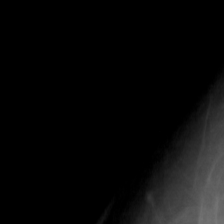

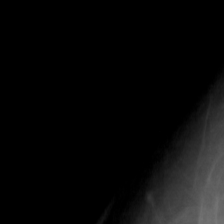

In [40]:
trans.ToPILImage()(patches[-1][2])

In [29]:
torch.cat(labels)

tensor([2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4,
        2, 2, 4, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4,
        2, 2, 4, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

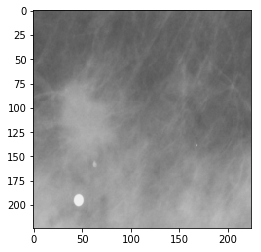

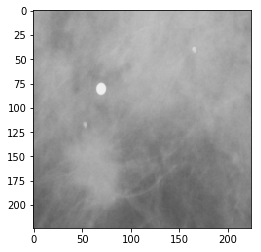

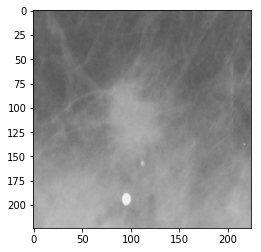

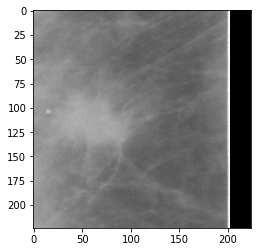

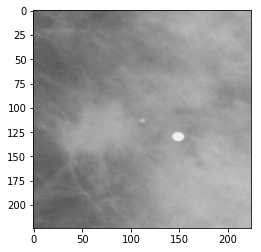

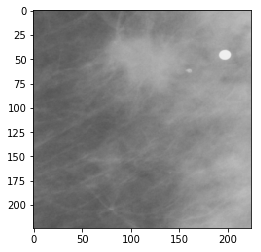

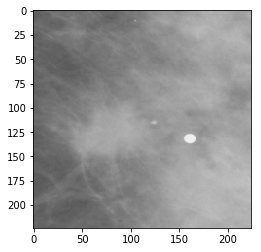

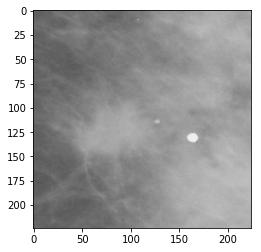

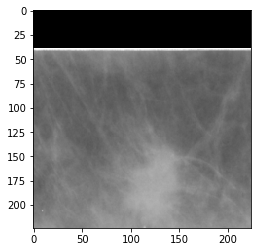

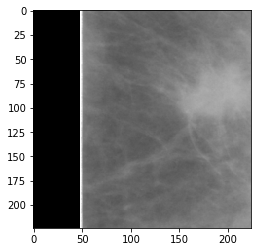

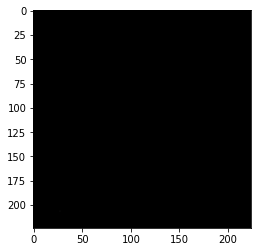

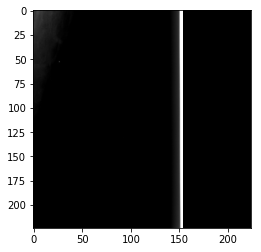

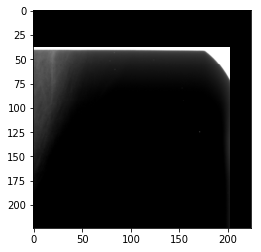

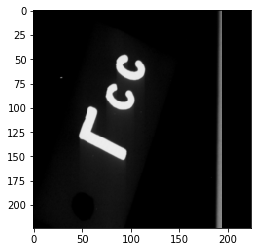

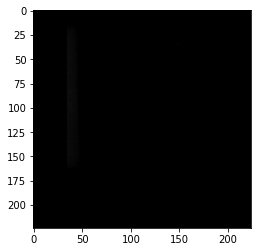

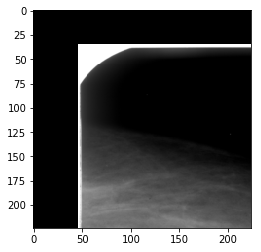

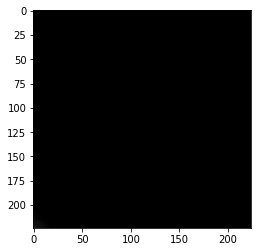

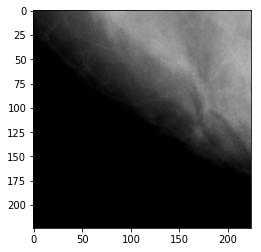

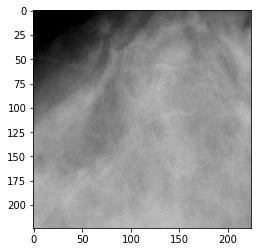

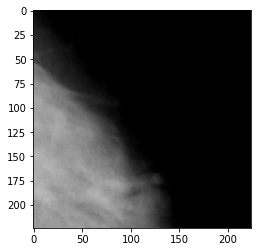

In [42]:
for i in range(len(res[0])):
    plt.figure()
    plt.imshow(res[0][i])

In [15]:
ds()

In [1]:
from ShapeLoader import ShapeDataSet as ds
from torch.utils.data import DataLoader

In [2]:
dloader_args = {
    'batch_size': 2,
    'pin_memory': False,
    'num_workers': 1,
    'drop_last': False,
}

In [3]:
loader = DataLoader(ds(), **dloader_args)

0
tensor([3, 0])


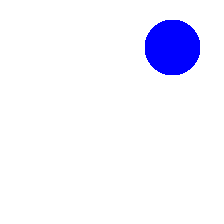

In [24]:
loader.dataset.set_mode('train')
print(loader.dataset.seed)
for im,label in loader:
    break
print(label)
trans.ToPILImage()(im[0])

10001
tensor([3, 0])


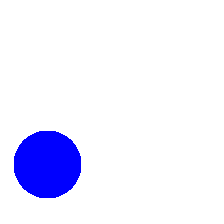

In [25]:
loader.dataset.set_mode('test')
print(loader.dataset.seed)
for im,label in loader:
    break
print(label)
trans.ToPILImage()(im[0])